In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import datetime
import json
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Part 1 ‐ Exploratory Data Analysis

In [2]:
#open json file

with open(r"C:\Users\Travi\Downloads\1631809090_1481053515_ultimate_challenge_3_\ultimate_challenge\logins.json") as f:
    data = json.load(f)

# Create DataFrame by converting the list into rows
logins = pd.DataFrame(data['login_time'], columns=['login_time'])

# Inspect Data

In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [4]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
#Convert log in times to datetime objects

logins = logins.apply(pd.to_datetime)

In [6]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
#Reset index 

logins.set_index('login_time', inplace=True)

In [8]:
logins.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [9]:
#Resample data into 15 min intervals

logins_counts = logins.resample('15T').size().reset_index(name='login_count')

In [10]:
logins_counts.set_index('login_time', inplace=True)

### Explore Data

First I wanted to look at the overall shape/frequancy of the data for all 4 months and look at the descriptive statistics.

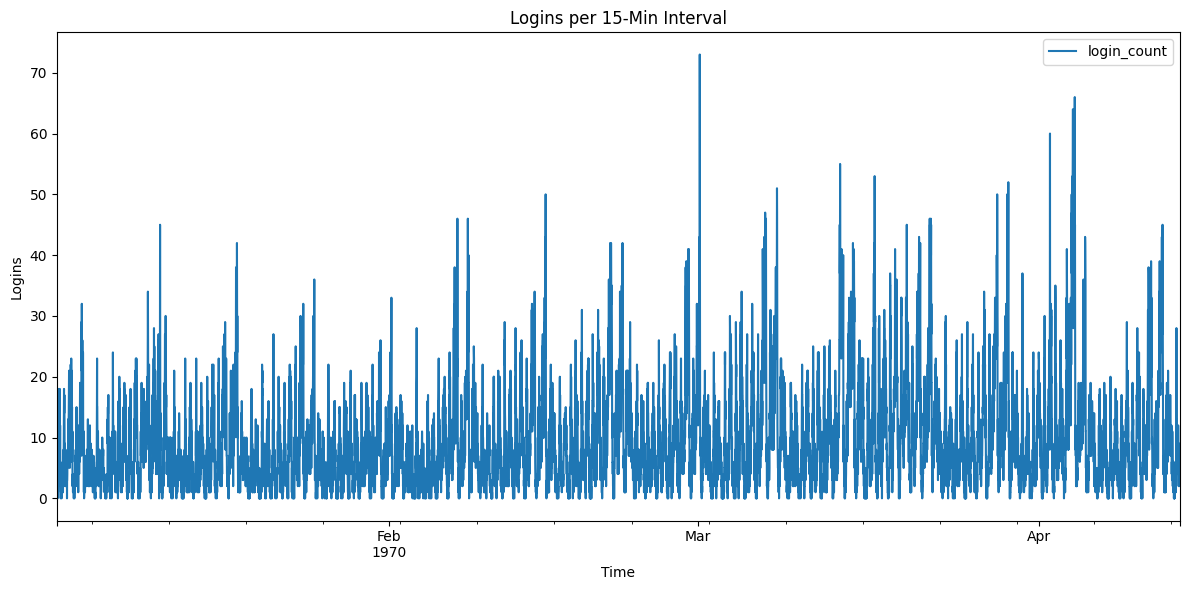

In [11]:
#15 minute login frequency from January through April

logins_counts.plot(figsize=(12, 6), title="Logins per 15-Min Interval")
plt.xlabel('Time')
plt.ylabel('Logins')
plt.tight_layout()
plt.show()

We can't really too see much from this graph, other than that demand rises with what looks like a constant period. This is most likely demand rising on the weekends.

In [12]:
logins_counts.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Next, I was interested in determining when those spikes of demand occured, weekday vs weekend.

In [13]:
#create new columns for items of interest

logins_counts = logins_counts.assign(month_day=logins_counts.index.day)
logins_counts = logins_counts.assign(weekday=logins_counts.index.weekday)
logins_counts.head()

,login_count,month_day,weekday
login_time,,,
1970-01-01 20:00:00,2,1,3
1970-01-01 20:15:00,6,1,3
1970-01-01 20:30:00,9,1,3
1970-01-01 20:45:00,7,1,3
1970-01-01 21:00:00,1,1,3


In [14]:
#Investigating spikes in logins 

spike = np.quantile(logins_counts,0.99)
df_spike = logins_counts[logins_counts['login_count'] >= spike]
month_days = []
weekdays = []
for date in df_spike.index:
    month_days.append(date.day)
    weekdays.append(date.weekday())
    
df_spike_days = pd.DataFrame(month_days,columns=['day'],index=range(len(month_days)))
df_spike_weekdays = pd.DataFrame(weekdays,columns=['weekday'],index=range(len(weekdays)))

In [15]:
df_spike_weekdays.weekday.value_counts()

weekday
5    104
6    103
4     48
3     15
2      7
1      7
0      2
Name: count, dtype: int64

It looks like we were correct the demand spikes greatly over the weekend. This makes sense since many people use ride share apps to go to social events or bars, which are frequented mostly on the weekends.  

Next, I wanted to view the daily frequency data.

In [16]:
#add count column for resample

logins['count'] = 1
logins.tail()

,count
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


<Axes: xlabel='login_time'>

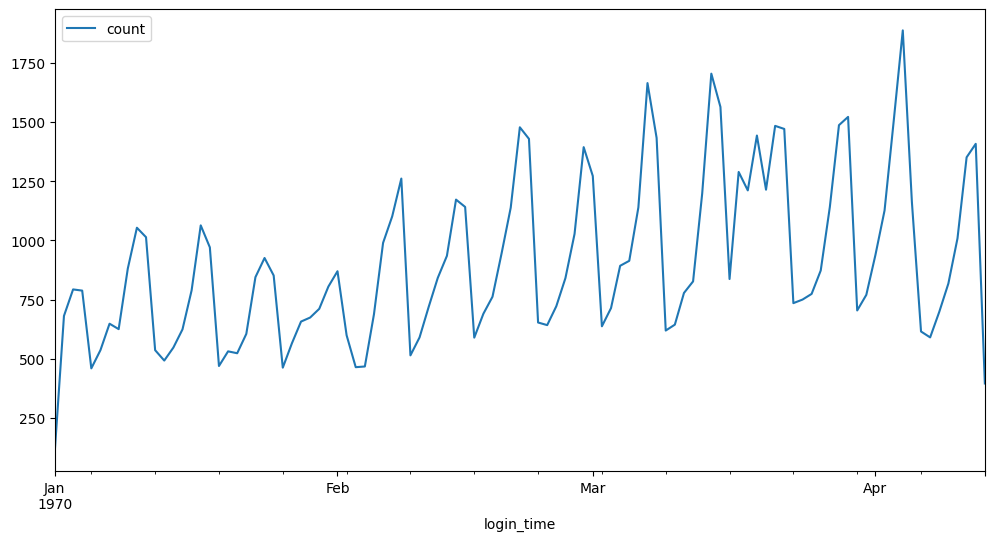

In [17]:
#resample to daily frequency

df_day = logins.resample('1D').sum()
df_day.plot(kind='line',figsize=(12,6))

Resampling to daily frequency shows there is an increasing trend of the average number of logins. At first, through the month of January, there seems to be little or no change in the average number of daily logins, then February starts the increasing trend. Linear model plots will confirm or deny this.

Text(0.5, 28.999999999999986, 'Day')

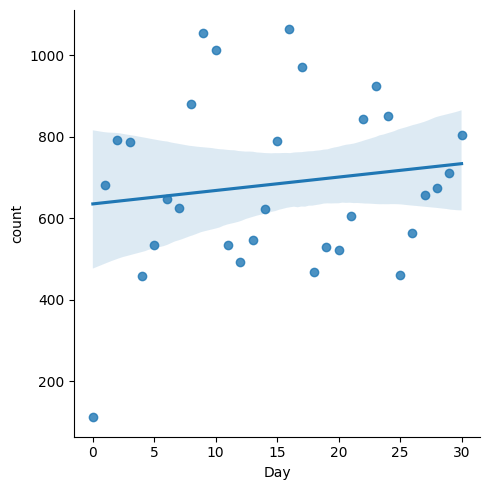

In [18]:
#plot January trend

plot_df = df_day[df_day.index.month==1]
plot_df = plot_df.assign(x = range(plot_df.shape[0]))
sns.lmplot(data=plot_df,x='x',y='count')
plt.xlabel('Day')

Text(0.5, 28.999999999999986, 'Day')

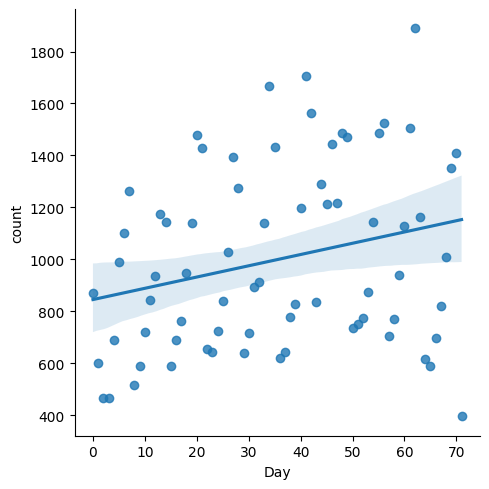

In [19]:
#plot Feb - April trend

plot_df = df_day[df_day.index.month!=1]
plot_df = plot_df.assign(x = range(plot_df.shape[0]))
sns.lmplot(data=plot_df,x='x',y='count')
plt.xlabel('Day')

It looks like we were correct, there wasn't much of an positive increase in logins during the month of January, but we do see a postive trend for the months between Feburary and April.  

Next, I wanted to plot demand just for the month of February to see if we can get more granular insights:

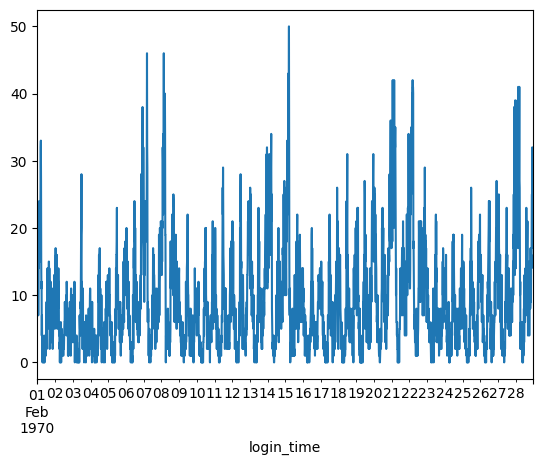

In [20]:
#Plot of demand for February 

logins_counts.loc['1970-02', 'login_count'].plot()
plt.show()

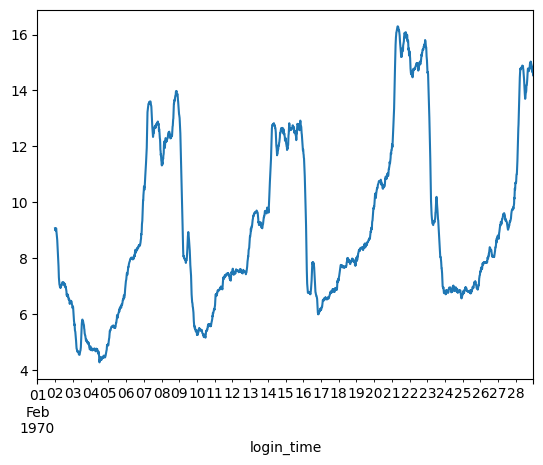

In [21]:
#Smoothed plot for February 

logins_counts.loc['1970-02', 'login_count'].rolling(window=96).mean().plot()
plt.show()

We can once again confirm demand clearly spikes on the weekends.  

Next, I was interested in determining if certian times during the day or night see increased demand. 

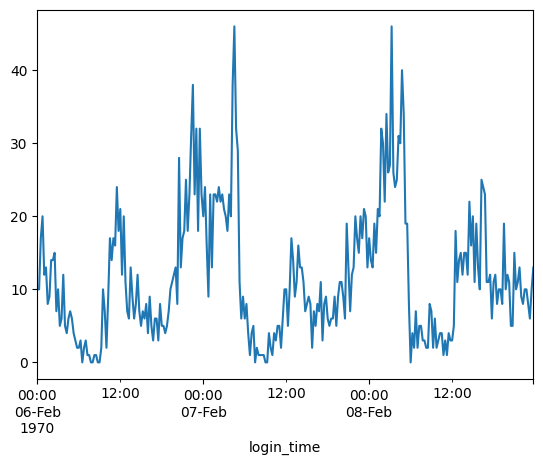

In [22]:
#Demand during a single weekend in February

logins_counts.loc['1970-02-06':'1970-02-08', 'login_count'].plot()
plt.show()

We can see a clear spike in demand during the times of noon and midnight on the weekend.  

Next, lets see if this pattern holds true for weekdays.

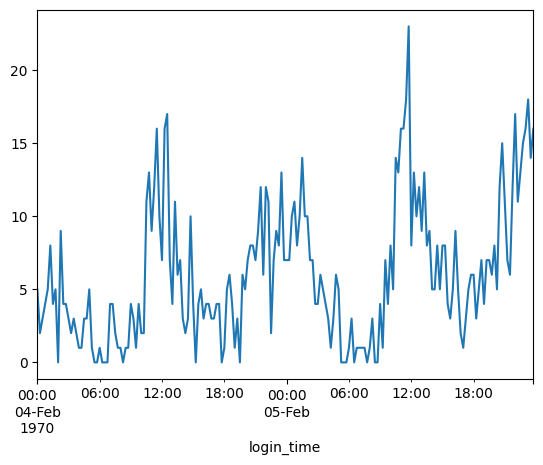

In [23]:
#2 day weekday demand in february

logins_counts.loc['1970-02-04':'1970-02-05', 'login_count'].plot()
plt.show()

Again, we see a clean spike in demand during noon and midnight during the week. This makes sense because many people could be using the app during lunch hours and around midnight when social events and bars begin to wind down and close for the night. 

For good measure, we will repeat this exploration for the month of March. 

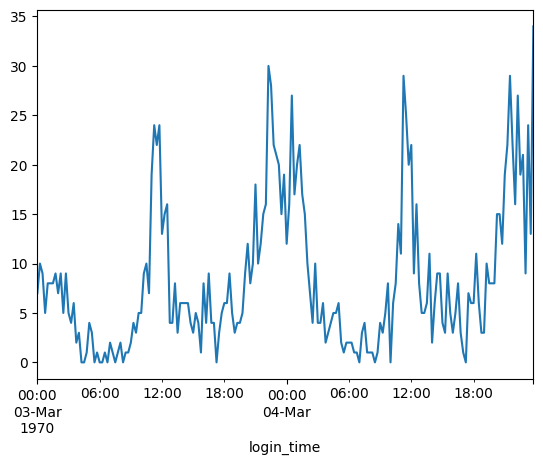

In [24]:
#2 day weekday demand in March

logins_counts.loc['1970-03-03':'1970-03-04', 'login_count'].plot()
plt.show()

Again, demand is highest at noon and and midnight.

So we can reach 2 broad conclusions from our exploration:

Demand is greater on the weekends than during the week.  
Demand is greatest around midnight and noon for both weekdays and weekends.

# Part 2 Experiment and Metrics Design 

1)	What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
  
Since Ultimate’s goal is to encourage drivers to split time between both cities, the key measure of success would be the percentage of cross-city trips per driver, let’s call this cross-city driving rate.  

With the idea of reimbursing tolls to get more drivers to serve both cities rather than sticking to just one, cross-city driving rate directly measures whether drivers are actually making trips in both cities. Other metrics, such as overall trip count, earnings, or active drivers could be affected for unrelated reasons (like general demand), so they're not as focused.  

2)	Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.

To help measure the effectiveness of the proposed change we could conduct a randomized controlled trial. Below is the proposed experimental setup:  


•	Randomly split all active drivers who usually serve Gotham, Metropolis, or both into 2 groups.  

    o	Control: Drivers that pay for tolls as they usually would. 
    o	Test Group: Drivers who will be reimbursed for the tolls.  
    
•	Conduct the experiment for at least a month or longer (4-6 weeks) to ensure that we capture weekday and weekend patterns.  

•	Monitor each driver’s trips in both cities and whether or not they cross the bridge.  


Import considerations:  

•	If possible, we want to ensure that the randomization of both the control and test group does not have a bias towards one city and is even in each group.  

•	We want to be mindful of holidays or special events that are happening in each city. This could skew the results of our experiment.  

•	Ensue test group is aware that they will be reimbursed for the tolls while on shift.  

•	Things like gas prices, road closures, or promotions could confound results.  


Statistical Test:  

Under the Central Limit Theorem, given a sufficiently large sample size, the sampling distribution of the mean will approach the normal distribution. We can use the normal distribution over the t-distribution, despite not knowing the population variance, because we will have a high degree of freedom in a large urban population. We will employ a two sample t-test at a chosen confidence level (99%), and test the samples under the following setup:  

    • H0: There is no difference in cross-city driving rate.  

    • Ha: There is a statistically significant difference in cross-city driving rate.  


We would use a significance level (α): 0.05 to determine if the results were statistically significant.

Results and Recommendations:  

•	If significant increase:  

    o	We can conclude that toll reimbursement does encourage more cross-city driving.
    o	We would then recommend rolling out toll reimbursement more broadly.  
    
•	If no significant increase:  

    o	Either the incentive is not strong enough, drivers value their home city more than the toll cost, or other factors such as familiarity, traffic, app design, ect. are at play.
    o	Recommendation would be to gather some qualitative data (surveys/interviews) to find out why there was not an increase in cross-city driving. 


# Part 3 Predictive Modeling

In [25]:
#Load data

with open(r"C:\Users\Travi\Downloads\1631809090_1481053515_ultimate_challenge_3_\ultimate_challenge\ultimate_data_challenge.json") as f:
    data = json.load(f)
df = pd.DataFrame(data)

### Data Exploration and Cleaning

I first wanted to get fimilar with the data to see if there was any missing values or if there was any issues with the data types.

In [26]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [28]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [29]:
#Check for missing values

df.isnull().sum().sort_values(ascending=False)

avg_rating_of_driver      8122
phone                      396
avg_rating_by_driver       201
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
dtype: int64

It looks like there are some data types that need to be converted to date times along with some missing values.  

I will now convert the signup_date and last_trip_date to datetime data types. I will then handle the missing values by imputing the average rating of drive and the average rating by driver

In [30]:
#Convert to datetime data types

df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [31]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [32]:
#Finding the average ratings for and by the driver to fill missing values

mean_of_driver = df['avg_rating_of_driver'].mean()
mean_by_driver = df['avg_rating_by_driver'].mean()

In [33]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(mean_of_driver)
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(mean_by_driver)

In [34]:
#Check remaining missing values

df.isnull().sum().sort_values(ascending=False)

phone                     396
city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [35]:
#Drop the reamining missing values because it would be hard to infer the phone type

df = df.dropna()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1)

In [37]:
#Determine the first and last sign up dates

print("First sign-up date was", df['last_trip_date'].min())
print("last sign-up date was",  df['last_trip_date'].max())

First sign-up date was 2014-01-01 00:00:00
last sign-up date was 2014-07-01 00:00:00


In [38]:
#Determine the percetage of retained users

retained = (df['last_trip_date']>= '2014-06-01').sum() / (df['last_trip_date'] <= '2014-06-01').count()
print(f'The percentage of users that were retained was {round(100*retained)}%')

The percentage of users that were retained was 38%


Now that we have determined the rate of retained users, we will explore possible correlations between the features and prepare the data for modeling.  

We will start by adding the retained column to our data set and explore the class balance. 

In [39]:
#Adding retained column to the data frame

df['retained'] = df['last_trip_date'] >= '2014-06-01'
df['retained'] = df['retained'].replace({True: 1, False: 0})
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


### EDA

In [40]:
#Checking class imbalance

(df['retained']== 0).value_counts()

retained
True     30933
False    18671
Name: count, dtype: int64

We will now encode our categorical features in order to explore correlation with a heatmap. 

In [41]:
#One-hot encode categorical features

cities_encoded = pd.get_dummies(df['city'])
phone_encoded = pd.get_dummies(df['phone'])
df = df.join(cities_encoded).join(phone_encoded)
df = df.drop(columns=['city', 'phone'])

In [42]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,Astapor,King's Landing,Winterfell,Android,iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,False,True,False,False,True
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,True,False,False,True,False
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,True,False,False,False,True
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,False,True,False,False,True
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,False,False,True,True,False


<Axes: >

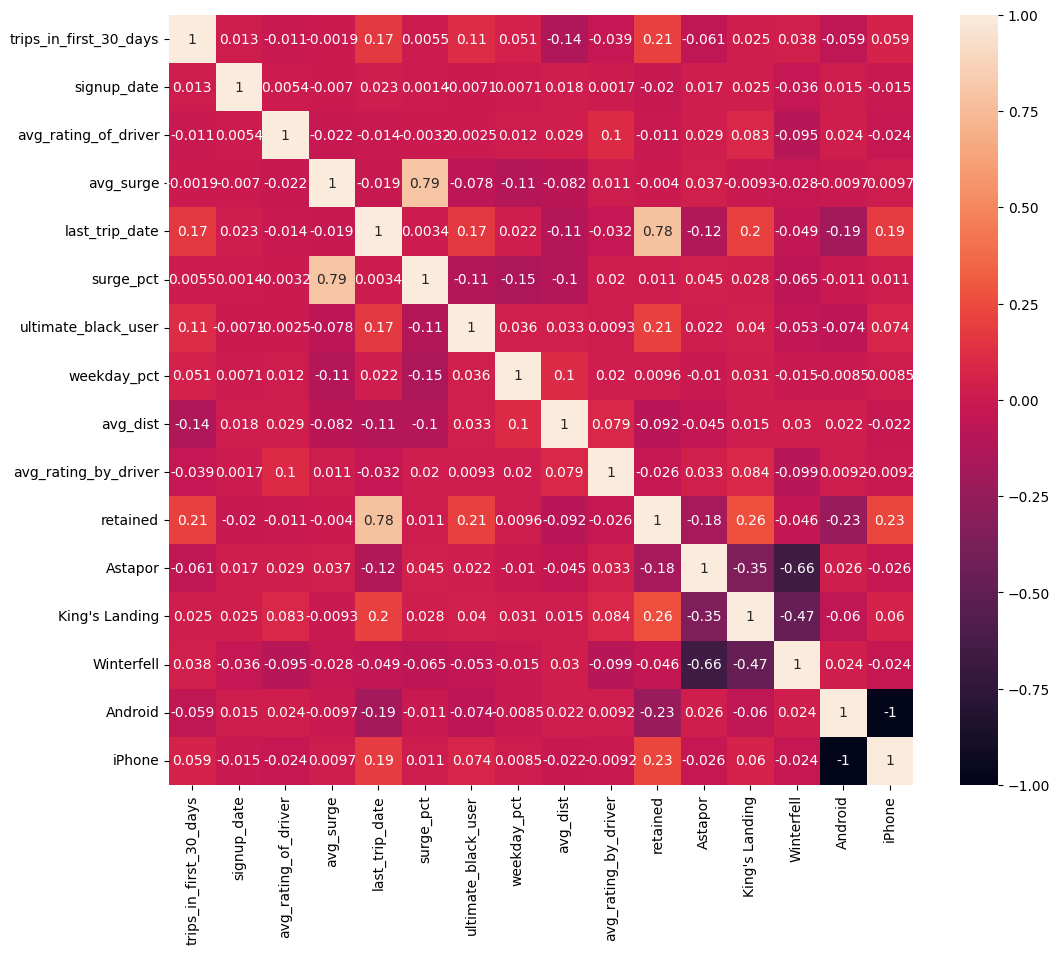

In [43]:
#Create heatmap for all features

plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, annot=True)

In [44]:
#Sort features by correlation

corr['retained'].sort_values(ascending=False)

retained                  1.000000
last_trip_date            0.780430
King's Landing            0.262398
iPhone                    0.227150
trips_in_first_30_days    0.210456
ultimate_black_user       0.206639
surge_pct                 0.011283
weekday_pct               0.009644
avg_surge                -0.004035
avg_rating_of_driver     -0.010589
signup_date              -0.020366
avg_rating_by_driver     -0.026330
Winterfell               -0.046400
avg_dist                 -0.092014
Astapor                  -0.175087
Android                  -0.227150
Name: retained, dtype: float64

As expected the last trip date is highly correlated to whether a user was retained or not. We also see some moderate correlation between the city, phone type, amount of trips taken in the first 30 days, and if the user was an ultimate black user.  

It appears that users from King's Landing and iPhone users have a positive correlation with retention. Whereas, Android users and those from the remaining 2 cities have a negative correlation. 

We will now check out what, if any, outliers that we may have in our data. 

<Axes: >

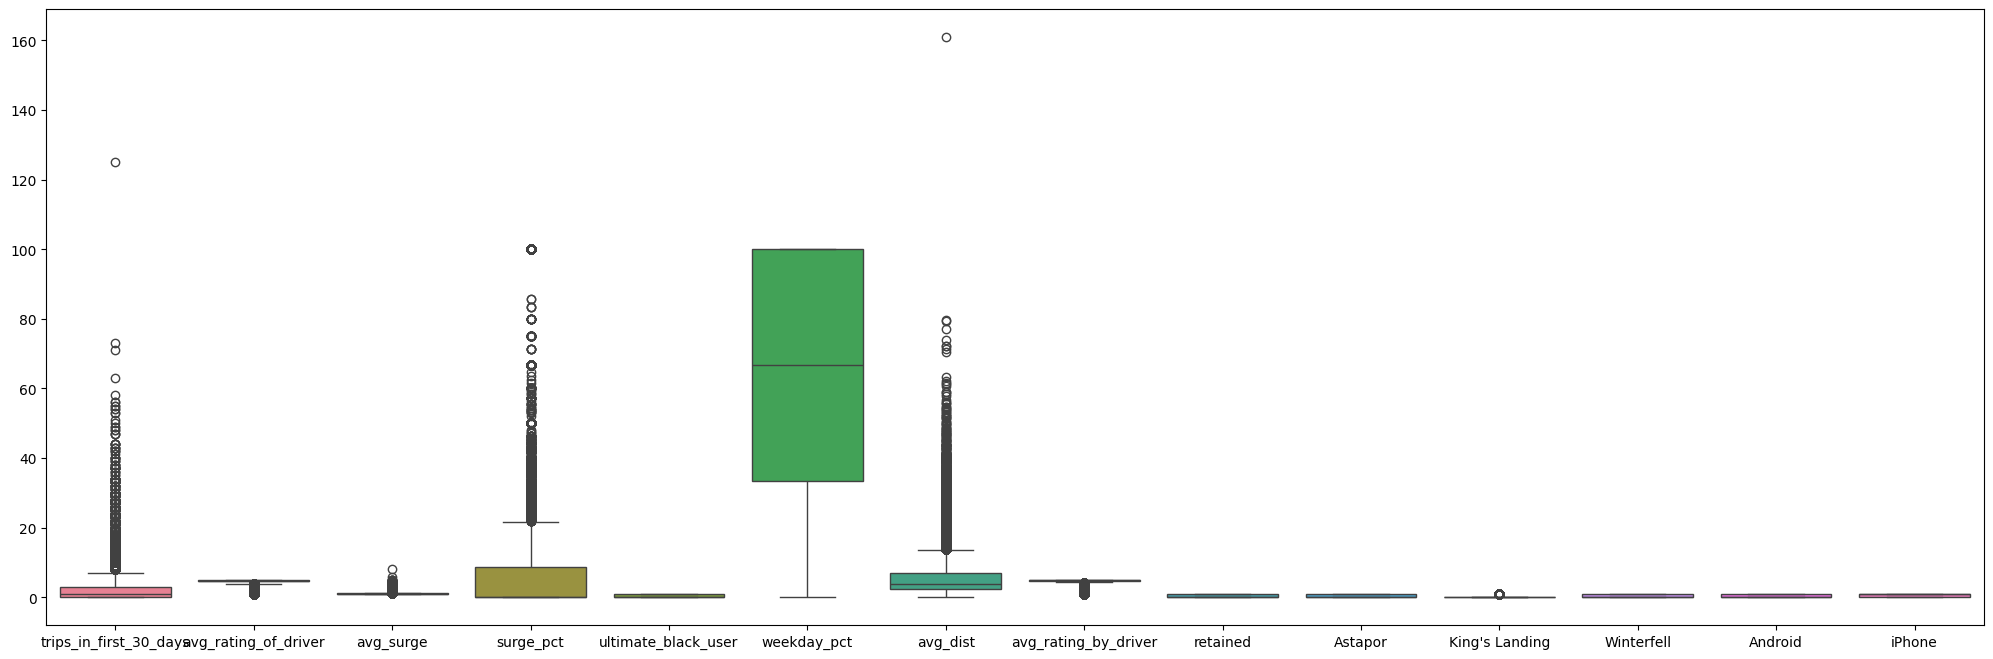

In [45]:
#Using boxplot to explore outliers

plt.figure(figsize=(25, 8))
sns.boxplot(data=df)

There do appear to be some outliers, however, we plan on testing the following models: Logistic regresssion, Random Forest, and XGBoost. In this case I do not believe these outliers will have an significant impact on our model preformance.  

These models were chosen because this is a binary classification problem. These models all have strengths that make them suitable for binary classification problems.

In [46]:
#Encode the reamining boolean columns

bool_columns = ['ultimate_black_user', "King's Landing", 'Winterfell', 'Astapor', 'iPhone', 'Android']
df[bool_columns] = df[bool_columns].replace({True: 1, False: 0})

### Modeling

In [47]:
#Convert sign up date to interger for modeling

df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [48]:
# Set our target variable

X = df.drop(columns=['retained','last_trip_date'])
y = df['retained']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Logistic Regression pipeline 

logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Random Forest pipeline 

rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

# XGBoost pipeline 

xgb_pipeline = Pipeline([
    ('clf', XGBClassifier(scale_pos_weight=1.66, eval_metric='logloss'))
])

# Evaluation function
def evaluate_model(pipeline, name):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(f"Evaluation for {name}:")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1 Score:", round(f1_score(y_test, y_pred), 3))
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Run evaluations
evaluate_model(logistic_pipeline, "Logistic Regression")
evaluate_model(rf_pipeline, "Random Forest")
evaluate_model(xgb_pipeline, "XGBoost")

Evaluation for Logistic Regression:
Accuracy: 0.716
Precision: 0.665
Recall: 0.492
F1 Score: 0.566
ROC AUC: 0.759
Evaluation for Random Forest:
Accuracy: 0.766
Precision: 0.711
Recall: 0.637
F1 Score: 0.672
ROC AUC: 0.831
Evaluation for XGBoost:
Accuracy: 0.773
Precision: 0.688
Recall: 0.728
F1 Score: 0.708
ROC AUC: 0.849


We are interested in determining if a user will be retained or not (aka a churn or not). For this we will use a combination of:

ROC AUC to determine how well the model separates classes.

Precision / Recall / F1 Score for practical impact.

and Confusion Matrix for insight into actual error types.

Using our baseline models we can see that our XGBoost model has the best performance. It has the highest ROC AUC score which shows decent class seperation. It also has the best precision, recall, and F1 score. 

Next, we will add hyperparameter tuning to our pipelines to see if we can imporve model performance. 

In [49]:
# Define pipelines

logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

xgb_pipeline = Pipeline([
    ('clf', XGBClassifier(eval_metric='logloss', random_state=42))
])

# Define parameter distributions
logistic_params = {
    'clf__C': uniform(0.001, 10),
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

rf_params = {
    'clf__n_estimators': randint(100, 300),
    'clf__max_depth': [None] + list(range(5, 20)),
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 5)
}

xgb_params = {
    'clf__n_estimators': randint(100, 300),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__subsample': uniform(0.7, 0.3),
    'clf__colsample_bytree': uniform(0.7, 0.3),
    'clf__scale_pos_weight': [1.0, 1.5, 1.7, 2.0, 3.0]
}

# Randomized SearchCV 
def run_random_search(pipeline, params, name, n_iter=20):
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    print(f"{name} Results")
    print("Best Params:", search.best_params_)
    print("Test ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Run searches
run_random_search(logistic_pipeline, logistic_params, "Logistic Regression")
run_random_search(rf_pipeline, rf_params, "Random Forest")
run_random_search(xgb_pipeline, xgb_params, "XGBoost")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Logistic Regression Results
Best Params: {'clf__C': 4.320450186421158, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Test ROC AUC: 0.759
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      6187
           1       0.66      0.49      0.57      3734

    accuracy                           0.72      9921
   macro avg       0.70      0.67      0.68      9921
weighted avg       0.71      0.72      0.70      9921

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Random Forest Results
Best Params: {'clf__max_depth': 11, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 249}
Test ROC AUC: 0.846
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      6187
           1       0.69      0.72      0.71      3734

    accuracy                           

After hyperparameter tuning we do see some impovements in our models. It looks like the XGBoost model provides us with the best balance for precision, recall, and F1 score. It also shows the highest accuracy of 78%  

Now we will examine the confusion matrix for all 3 models to get an idea of the false positive and false negative rates.

In [50]:
#Creating confusion matrix

def evaluate_model_2(pipeline, X_test, y_test, model_name='Model'):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Inactive", "Active"])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

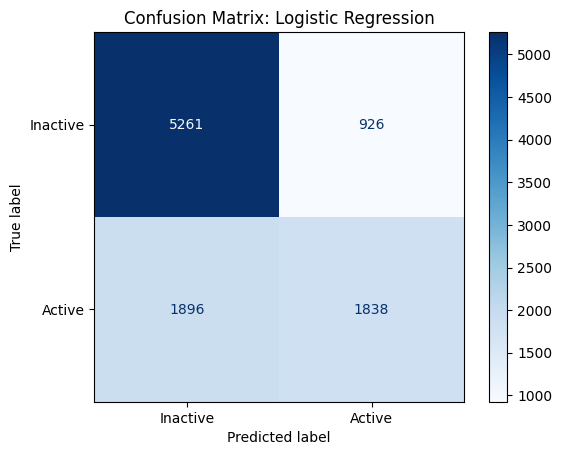

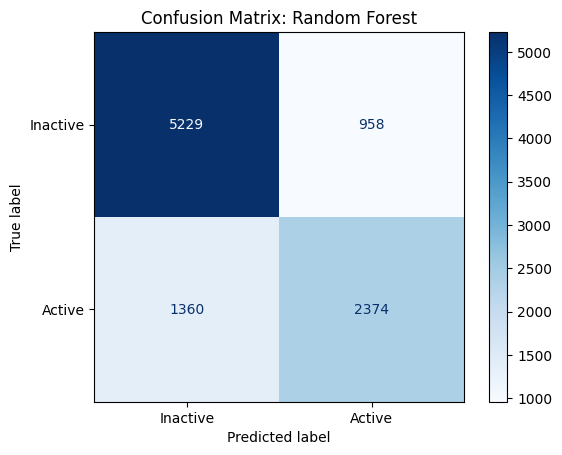

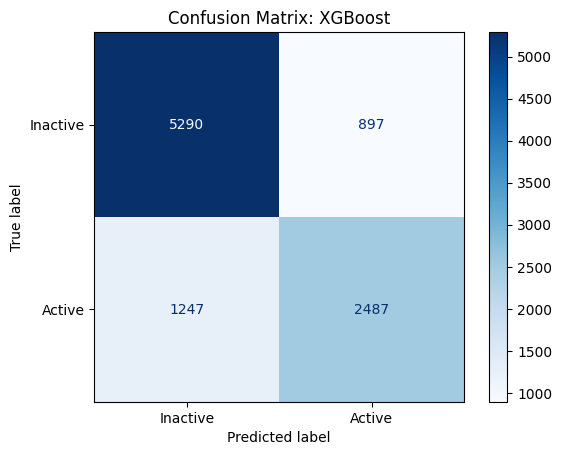

In [51]:
evaluate_model_2(logistic_pipeline, X_test, y_test, "Logistic Regression")
evaluate_model_2(rf_pipeline, X_test, y_test, "Random Forest")
evaluate_model_2(xgb_pipeline, X_test, y_test, "XGBoost")

In [52]:
#Get feature names to use for feature importance

feature_names = X_train.columns

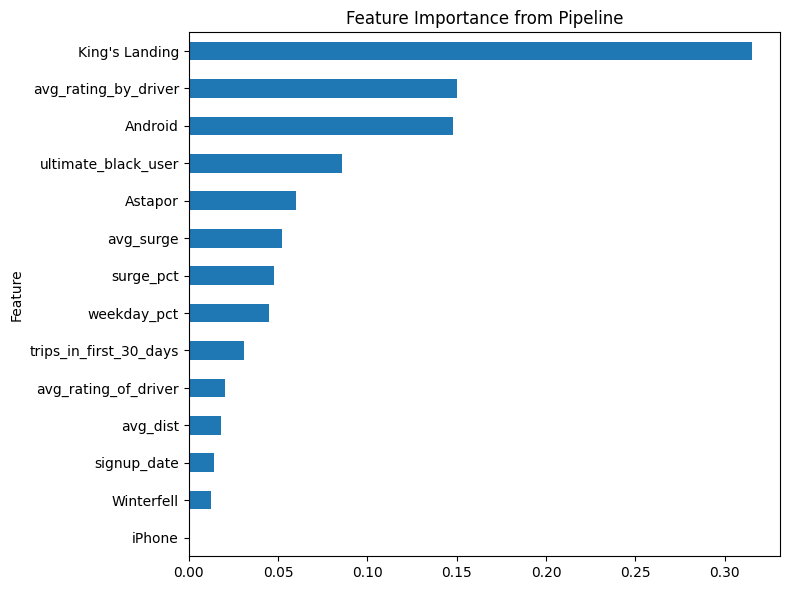

In [53]:
#Feature importance from XGBoost model

importances = xgb_pipeline.named_steps['clf'].feature_importances_

xg_feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
xg_feat_df = xg_feat_df.sort_values(by='Importance', ascending=False)

xg_feat_df.plot(kind='barh', x='Feature', y='Importance', figsize=(8,6), legend=False)
plt.gca().invert_yaxis()
plt.title("Feature Importance from Pipeline")
plt.tight_layout()
plt.show()

Let's visualize and explore some of the top features from our model. 

In [54]:
def plot_retention_by_feature(df, feature_name, bins=None, title=None, return_stats=True):
 
    data = df.copy()

    if set(data[feature_name].unique()) <= {0, 1} and data[feature_name].dtype in ['int64', 'float64']:
        data = data[data[feature_name] == 1][['retained']].copy()
        data['category'] = feature_name
    else:
        if bins is not None:
            data['category'] = pd.cut(data[feature_name], bins=bins)
        else:
            data['category'] = data[feature_name]


    # Group and calculate counts
    count_data = data.groupby(['category', 'retained']).size().unstack(fill_value=0)

    # Plot
    count_data.plot(kind='bar', stacked=False, colormap='Set2')
    plt.title(title or f'Retention by {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('User Count')
    plt.legend(title='Retained', labels=['Not Retained', 'Retained'])
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Calculate retention rate
    retention_rate = count_data.copy()
    retention_rate['Total'] = retention_rate[0] + retention_rate[1]
    retention_rate['Retention Rate (%)'] = (retention_rate[1] / retention_rate['Total'] * 100).round(2)

    if return_stats:
        return retention_rate[['Total', 'Retention Rate (%)']]

In [ ]:
retention_by_city = plot_retention_by_feature(df, "iPhone", title="iPhone users")
print(retention_by_city)

In [ ]:
retention_by_city = plot_retention_by_feature(df, "Android", title="Retention by Android users")
print(retention_by_city)

In [ ]:
retention_by_city = plot_retention_by_feature(df, "King's Landing", title="Retention by King's Landing")
print(retention_by_city)

In [ ]:
retention_by_city = plot_retention_by_feature(df, "Winterfell", title="Retention by Winterfell")
print(retention_by_city)

In [ ]:
retention_by_city = plot_retention_by_feature(df, "Astapor", title="Retention by Astapor")
print(retention_by_city)

In [ ]:
retention_by_rating = plot_retention_by_feature(df, 'avg_rating_by_driver',bins=[0, 3.5, 4.0, 4.5, 5.0],
                                                title='Avgerage rating by driver')
print(retention_by_rating)

In [ ]:
retention_by_city = plot_retention_by_feature(df, "ultimate_black_user", title="Retention by Ultimate Black Users")
print(retention_by_city)

In [ ]:
retention_by_city = plot_retention_by_feature(df, "trips_in_first_30_days", bins=[0, 5, 10, 15, 20, 25, 30], title="Retention by Trips in first 30 days")
print(retention_by_city)

In conclusion, we have extracted very valuable information from this dataset.  

After hyperparmeter tuning, the XGBoost model still provided the best performance slightly outperforming our Random Forest model. It also had the least false positive and false negative rates among the models that were tested. 

The insights from the model are arguably more important and lucrative for the company.  

When examining the top features of our model we found some interesting correlations.

1. User's from King's Landing had a 63% retention rate compared to 35% and 26% from Winterfell and Astapor, respectively.
2. iPhone users had over double the retention rate of Android users. This is interesting since our model showed that the Android feature had more importance than iPhone.
3. Retention rates are the highest when the average rating by the driver is between 4 and 4.5. However, the 4.5 to 5 category had almost 9 times as many ratings compared to the 4 4.5 ratings. This shows the majority of drivers are rating passengers very high between 4.5 and 5.
4. Retention rates significantly jump when a user takes more that 5 rides int he first 30 days.   

Based on these insights gained from the model, there are several recommendations for the company.  

1.	Offer additional incentives or run more targeted ad Campaigns to users in the cities of Winterfell and Astapor.
2.  Offer more promotions for Android users.
4.	Encourage drivers not to artificially inflate the ratings they give to users.
5.  Incentivize riders to take more trips during their first 30 days on the app
